# Evalution and Analysis

## Imports:

In [1]:
from pathlib import Path
from Helper.evaluation_helpers import get_predictions, calc_metrics, error_plot,plot_metric
import warnings
from matplotlib import pyplot as plt

### Supress warnings

In [2]:
warnings.filterwarnings("ignore") 

In [3]:
import numpy as np
from pathlib import Path

predsPath = Path('../Predictions/')
for i in list(predsPath.glob('*.npy')):
    data = np.load(i)
    print(f" {i.name} has {len(data)} values")  # Show length of each prediction file


 ARDL.npy has 12 values
 GRU.npy has 48 values
 LSTM.npy has 12 values
 MLR.npy has 48 values
 Naive.npy has 48 values
 NBEATSx.npy has 12 values
 NHITS.npy has 12 values
 Random_Forest_X.npy has 12 values
 RNN.npy has 48 values
 Tide.npy has 12 values
 VAR.npy has 12 values
 XGB.npy has 48 values


In [4]:
# metric DataFrames are sorted by the main metric before being displayed
main_metric = 'RMSE'

# Horizon = 1:

,RMSE,MAE,r2
ARIMAX1990,0.261509,0.215859,0.873131
SARIMAX1990,0.269689,0.25457,0.865069
ARIMA1990,0.278222,0.22374,0.856396
SARIMA1990,0.33694,0.285122,0.789385
TFT,2.680355,2.576154,-12.32812


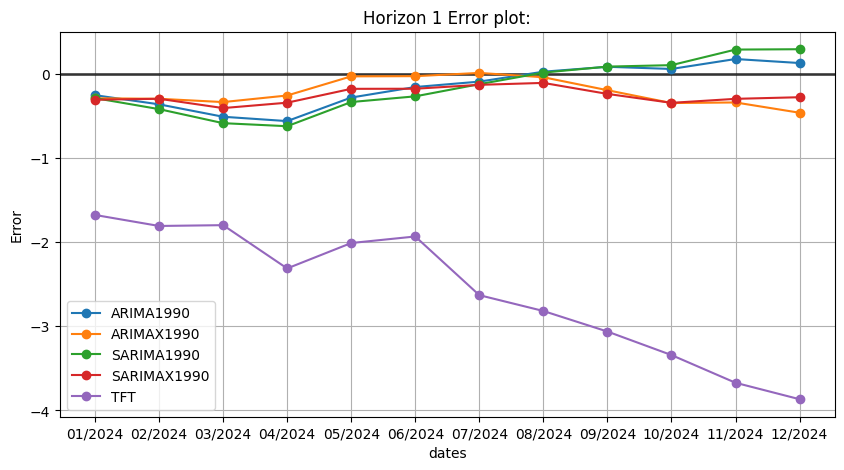

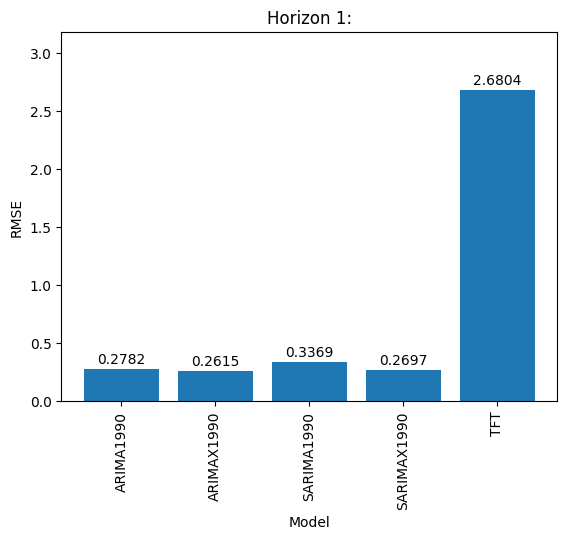

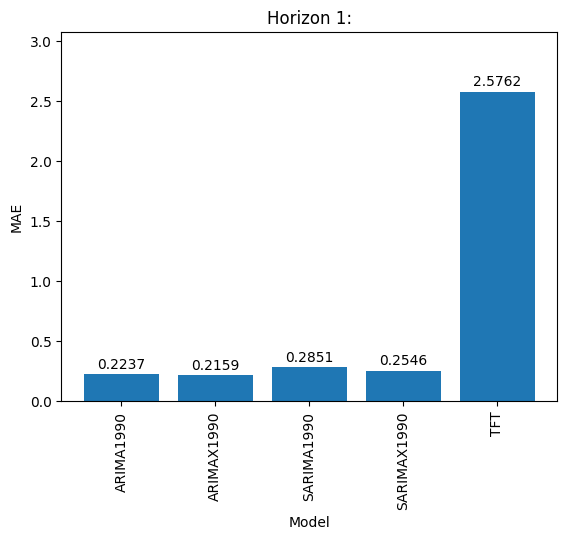

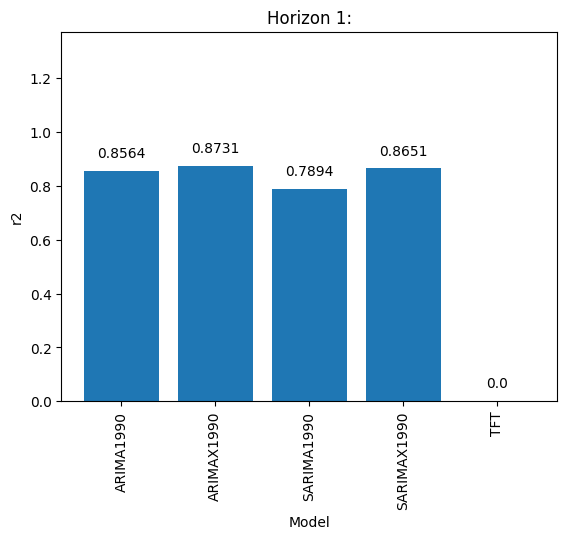

In [9]:
predsPath_1= Path('../Predictions/Horizon1')
predsDf_1=get_predictions(predsPath_1)

metrics_1= calc_metrics(predsDf_1)
display(metrics_1.sort_values(main_metric, axis=0))

error_plot(predsDf_1,model='all',absolute=False, title= 'Horizon 1 Error plot:')

for i in metrics_1.columns:
    plot_metric(metrics_1,i,model='all', title='Horizon 1:')

# Horizon = 3:

,RMSE,MAE,r2
TFT,2.067248,1.758727,-6.928104


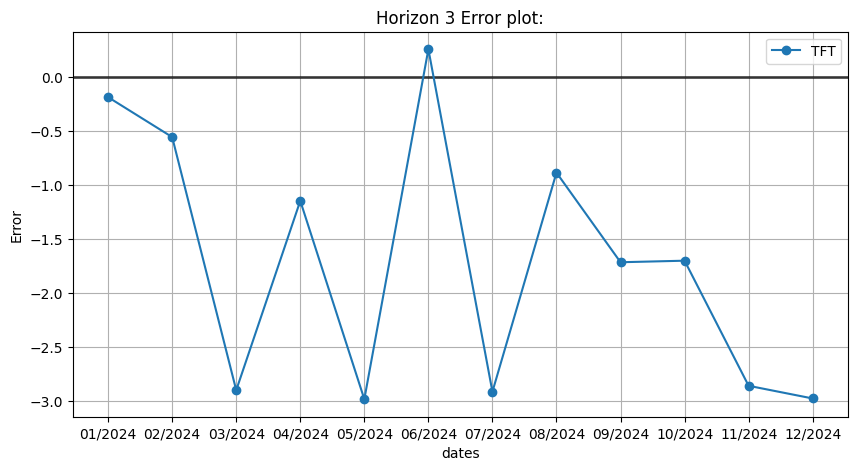

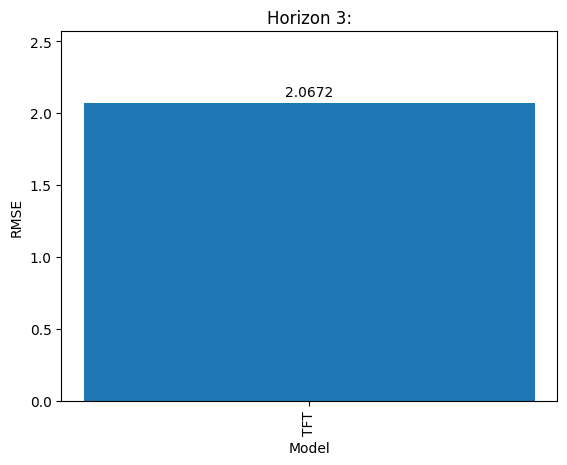

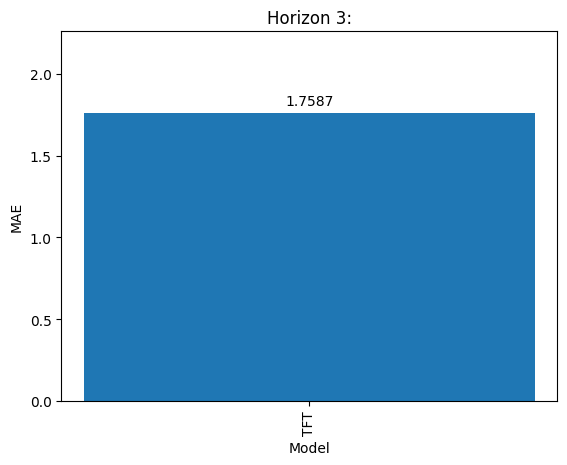

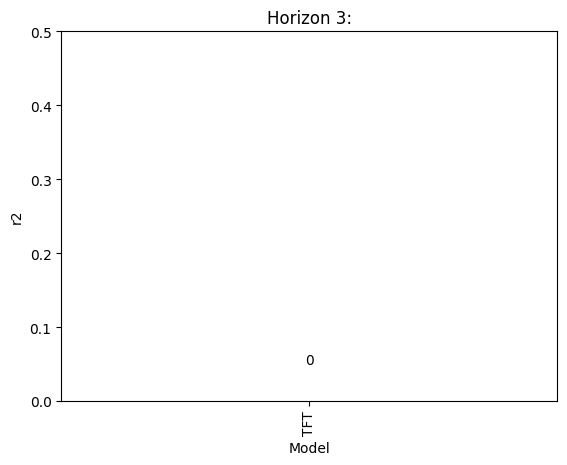

In [6]:
predsPath_3= Path('../Predictions/Horizon3')
predsDf_3=get_predictions(predsPath_3)

metrics_3= calc_metrics(predsDf_3)
display(metrics_3.sort_values(main_metric, axis=0))

error_plot(predsDf_3,model='all',absolute=False, title= 'Horizon 3 Error plot:')
for i in metrics_3.columns:
    plot_metric(metrics_3,i, title='Horizon 3:')

# Horizon = 6:

,RMSE,MAE,r2
TFT,4.017051,3.970676,-28.93634


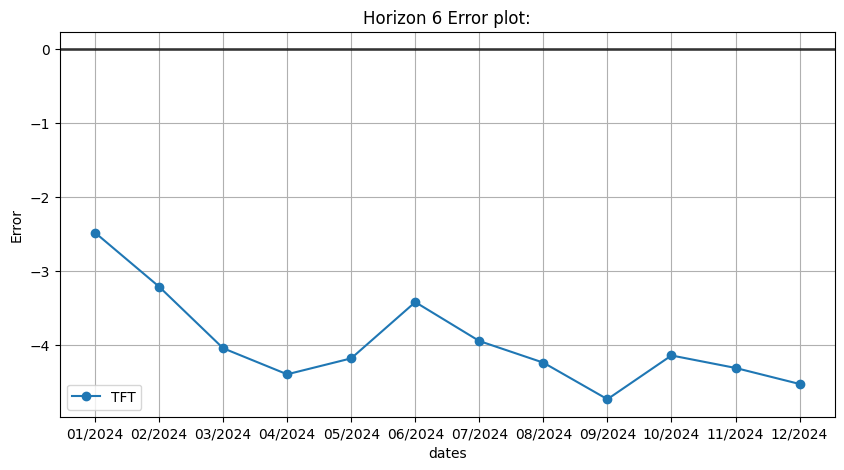

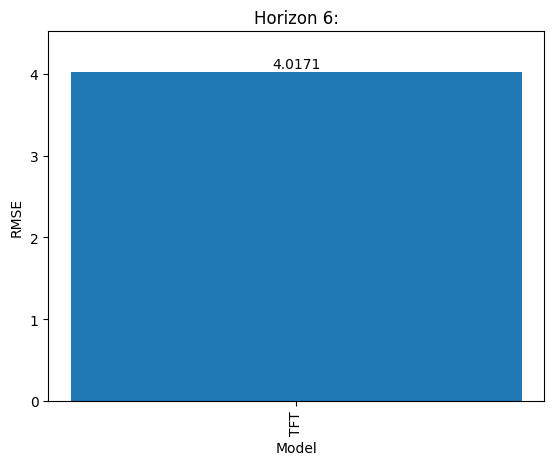

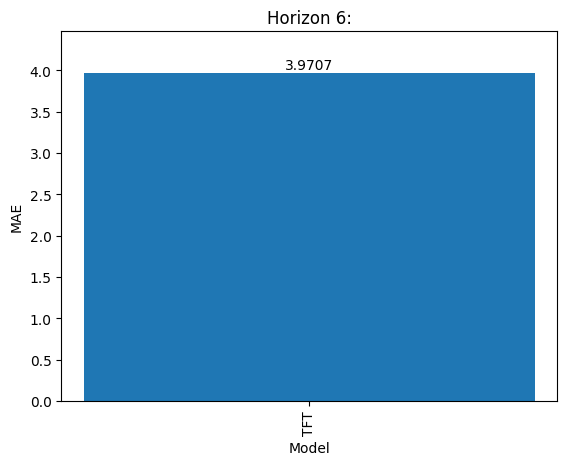

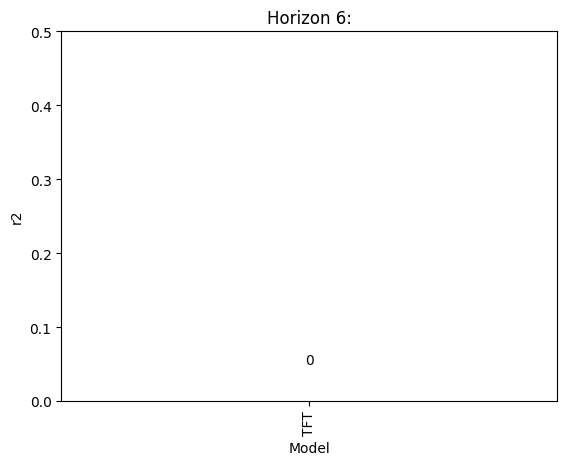

In [7]:
predsPath_6= Path('../Predictions/Horizon6')
predsDf_6=get_predictions(predsPath_6)

metrics_6= calc_metrics(predsDf_6)
display(metrics_6.sort_values(main_metric, axis=0))

error_plot(predsDf_6,model='all',absolute=False, title= 'Horizon 6 Error plot:')
for i in metrics_6.columns:
    plot_metric(metrics_6,i, title='Horizon 6:')

# Horizon = 12:

,RMSE,MAE,r2
TFT,4.180308,3.922822,-31.419083


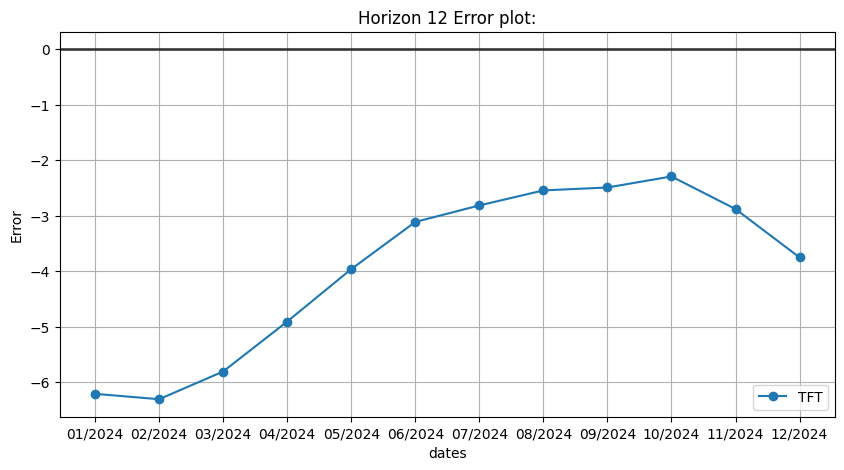

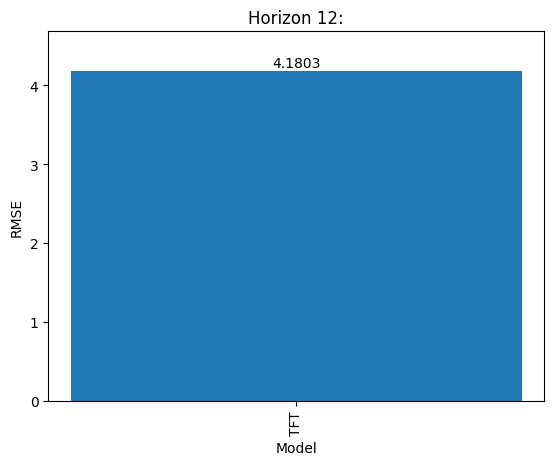

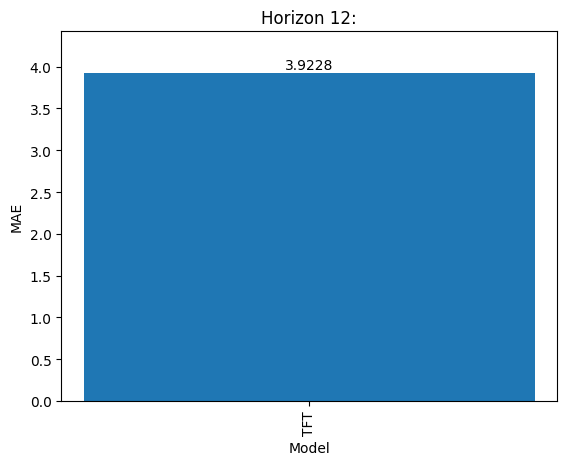

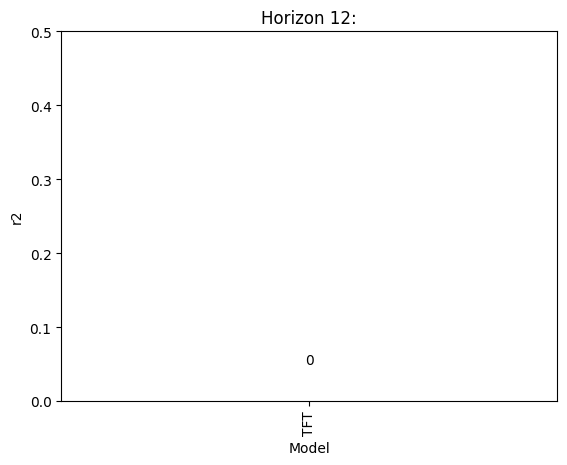

In [8]:
predsPath_12= Path('../Predictions/Horizon12')
predsDf_12=get_predictions(predsPath_12)

metrics_12= calc_metrics(predsDf_12)
display(metrics_12.sort_values(main_metric, axis=0))

error_plot(predsDf_12,model='all',absolute=False, title= 'Horizon 12 Error plot:')
for i in metrics_12.columns:
    plot_metric(metrics_12,i, title='Horizon 12:')